In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

# Reading, Preprocessing and EDA

In [30]:
train_df = pd.read_csv('../datasets/p53Mutant/p53_new_2012/Data Sets/K9.data',header = None, low_memory=False)

In [31]:
train_df.shape

(31420, 5410)

In [32]:
train_df.drop(columns={5409}, inplace=True)

In [33]:
print(train_df.isnull().sum().sum(), train_df.isna().sum().sum())

0 0


In [34]:
columns = train_df.columns

In [35]:
columns[-1]

5408

In [36]:
targets = train_df[5408]
print(len(targets))

31420


In [37]:
for col in train_df.columns:
    if(len(train_df[col].unique()) == 1):
        print(len(train_df[col].unique()))

In [38]:
missing_in_row = []
delete_row = []
for row in range(len(train_df)):
    temp = (train_df.loc[row] == '?').sum()
    missing_in_row.append(temp)
    if(temp>100):
        delete_row.append(row)
missing_in_row = pd.Series(missing_in_row, dtype = float)
print(missing_in_row.value_counts())

0.0       31159
5408.0      137
4826.0      124
dtype: int64


In [39]:
missing_in_column = []
delete_column = []
for col in train_df.columns:
    temp = (train_df[col] == '?').sum()
    missing_in_column.append(temp)
    if(temp > 100):
        delete_column.append(col)
missing_in_column = pd.Series(missing_in_column, dtype = float)
print(missing_in_column.value_counts())    

261.0    4826
137.0     582
0.0         1
dtype: int64


In [40]:
train_df.drop(delete_row, axis=0, inplace=True)

In [41]:
missing_in_column = []
for col in train_df.columns:
    missing_in_column.append((train_df[col] == '?').sum())
missing_in_column = pd.Series(missing_in_column, dtype = float)
print(missing_in_column.value_counts())    

0.0    5409
dtype: int64


In [42]:
unique_val= []
for col in train_df.columns:
    unique_val.append(len(train_df[col].unique()))
print(pd.Series(unique_val).value_counts())

500     14
534     12
617     11
546     11
526     10
        ..
1917     1
135      1
171      1
1988     1
2        1
Length: 2893, dtype: int64


In [43]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5399,5400,5401,5402,5403,5404,5405,5406,5407,5408
0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,...,0.006,0.013,0.021,0.02,0.016,-0.011,0.003,0.01,-0.007,inactive
1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,...,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,inactive
3,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,...,0.019,0.01,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,inactive
4,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,...,0.051,0.012,0.05,0.038,0.051,-0.015,0.017,0.027,-0.049,inactive
5,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,...,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,inactive


In [44]:
train_df.reset_index()
# train_df.drop(columns = ['index'])

,index,0,1,2,3,4,5,6,7,8,...,5399,5400,5401,5402,5403,5404,5405,5406,5407,5408
0,0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,...,0.006,0.013,0.021,0.02,0.016,-0.011,0.003,0.01,-0.007,inactive
1,1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,...,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,inactive
2,3,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,...,0.019,0.01,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,inactive
3,4,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,...,0.051,0.012,0.05,0.038,0.051,-0.015,0.017,0.027,-0.049,inactive
4,5,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,...,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31154,31415,-0.005,-0.023,0.018,-0.016,-0.045,0.053,0.021,0.003,0.004,...,0.006,0.032,-0.059,0.03,0.017,0.005,0.142,0.075,-0.03,inactive
31155,31416,0.001,0.008,-0.001,0.012,0.020,-0.020,-0.008,-0.004,-0.003,...,-0.01,0.002,-0.077,0.031,-0.042,0.034,0.188,0.077,0.021,inactive
31156,31417,0.002,0.013,-0.002,0.016,0.031,-0.026,-0.011,-0.005,-0.004,...,-0.012,-0.013,-0.065,0.002,-0.039,0.05,0.163,0.075,0.031,inactive
31157,31418,-0.002,-0.012,0.002,-0.018,-0.027,0.036,0.013,0.005,0.006,...,0.015,0.011,-0.041,0.015,0.005,0.055,0.2,0.103,0.018,inactive


In [45]:
train_df.shape

(31159, 5409)

In [46]:
train_df, test_df = train_test_split(train_df, train_size = 0.9, random_state = 42) 
y_train = train_df[5408]
y_test = test_df[5408]
X_train = train_df.drop(columns = [5408], axis = 0)
X_test = test_df.drop(columns = [5408], axis = 0)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [47]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [48]:
X_train = X_train.astype('float64')
y_train = y_train.astype('float64')
X_test = X_test.astype('float64')
y_test = y_test.astype('float64')

In [49]:
def score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.6f}")
    print(f"Error Rate: {1-acc}")
    Recall = recall_score(y_test, y_pred, average='macro')      
    print(f"Mean Recall: {Recall}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
    Array_prec_recall_f = precision_recall_fscore_support(y_test, y_pred, average='macro')
#                                                                         average = 'micro', 'macro', 'weighted'
    print(f"Precision: {Array_prec_recall_f[0]}")
    print(f"F-Score: {Array_prec_recall_f[2]}")
          
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    print(len(y_pred), len(y_test))
    for i in range(len(y_pred)): 
        if y_test[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_test[i]!=y_pred[i]:
           FP += 1
        if y_test[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    if TN + FP == 0: 
      Selectivity = 0
    else:
      Selectivity = TN/(TN + FP)
    G_mean = np.sqrt(Selectivity*Recall) 
    print(f"Selectivity: {Selectivity}") 
    print(f"G_mean: {G_mean}")   
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   
        

In [50]:
class CentroidSMOTE():
    def __init__(self, sampling_strategy='auto', random_state=42, k_neighbors=5, m_vertices=3):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.m_vertices = m_vertices
    
    @staticmethod
    def nearest_neighbor(X, k):
        from sklearn.neighbors import NearestNeighbors
        nbs=NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(X)
        euclidean,indices= nbs.kneighbors(X)
        return indices[:, 1:]
    
    def fit_resample(self, X, y):
        
        (unique, freq) = np.unique(y, return_counts=True)
        frequency = dict(zip(unique, freq))
        max_frequency = max(frequency.values())
        
        if self.sampling_strategy == 'auto':
            sampling_strategy = {}
            for (key, value) in frequency.items():
                sampling_strategy[key] = max_frequency - value
            self.sampling_strategy = sampling_strategy
            
        data = {}
        for (key, value) in self.sampling_strategy.items():
            if value == 0:
                continue
            X_small = X[y == key]
            indices = self.nearest_neighbor(X_small, self.k_neighbors)
            new_data = []
            for idx in np.random.choice(np.arange(len(X_small)), size=value):
                p = X_small[idx]
                nnarray = indices[idx]
                q = X_small[np.random.choice(nnarray, size=self.m_vertices-1, replace=False)]
                new_data.append(np.sum(np.vstack([p, q]), axis=0)/int(self.m_vertices))
            X_new = np.vstack(new_data)
            data[key] = X_new
        
        for (key, value) in data.items():
            X = np.vstack([X, value])
            y = np.concatenate([y, np.ones(len(value))*key])
        
        X, y = shuffle(X, y, random_state=self.random_state)
        
        return X, y        

In [51]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.996470
Error Rate: 0.003530166880616137
Mean Recall: 0.5769230769230769
Balanced Accuracy Score: 0.5769230769230769
Precision: 0.9982337829158638
F-Score: 0.6324486622701195
3116 3116
Selectivity: 0.15384615384615385
G_mean: 0.297921795862109


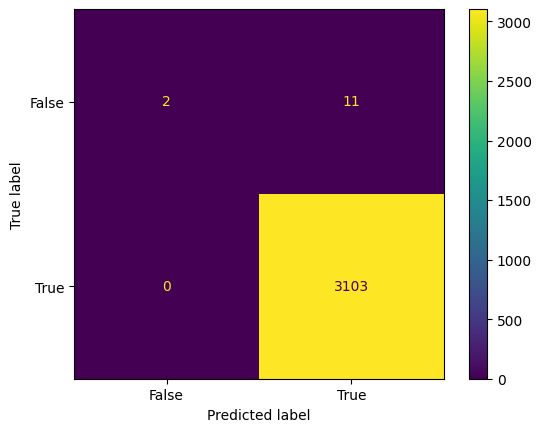

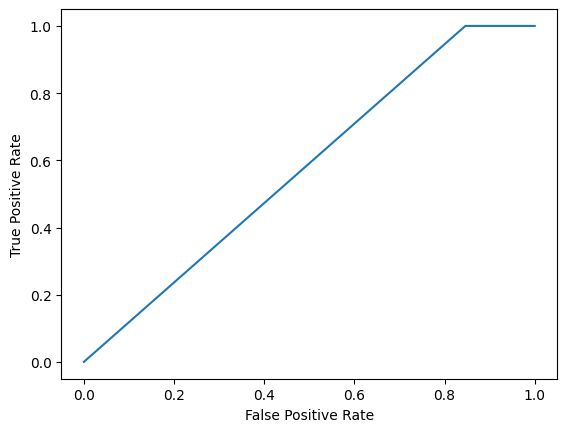

In [52]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.990051
Error Rate: 0.009948652118100143
Mean Recall: 0.8418032177297404
Balanced Accuracy Score: 0.8418032177297404
Precision: 0.6243506493506494
F-Score: 0.6811665957018421
3116 3116
Selectivity: 0.6923076923076923
G_mean: 0.7634047701211111


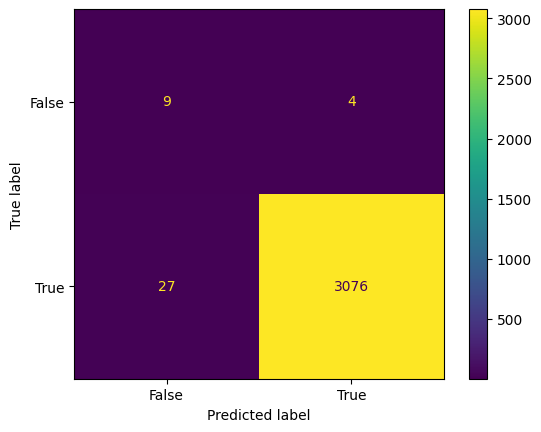

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.989730
Error Rate: 0.010269576379974277
Mean Recall: 0.8416420833436624
Balanced Accuracy Score: 0.8416420833436624
Precision: 0.6209720600756652
F-Score: 0.6774118408282109
3116 3116
Selectivity: 0.6923076923076923
G_mean: 0.7633317027797871


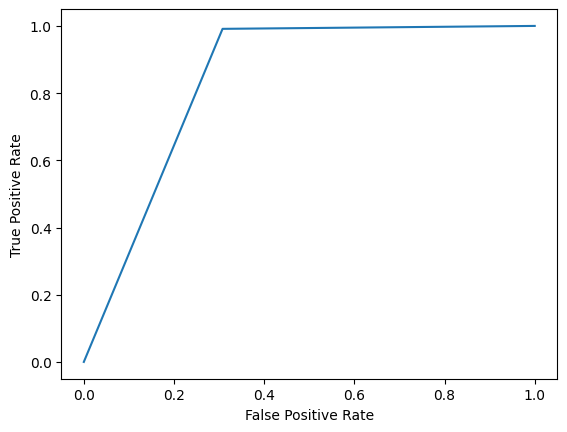

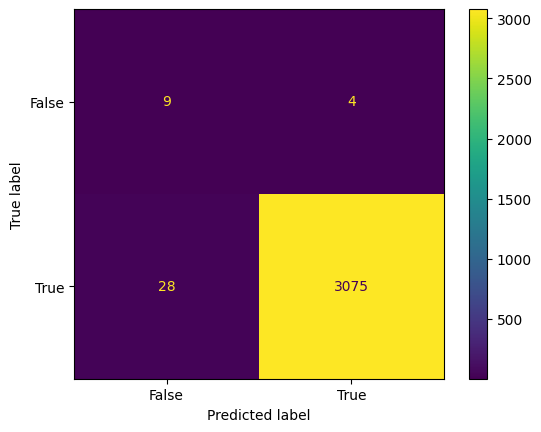

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.989409
Error Rate: 0.010590500641848521
Mean Recall: 0.8797813530330449
Balanced Accuracy Score: 0.8797813530330449
Precision: 0.6245123537061119
F-Score: 0.6860089102773546
3116 3116
Selectivity: 0.7692307692307693
G_mean: 0.8226511331958987


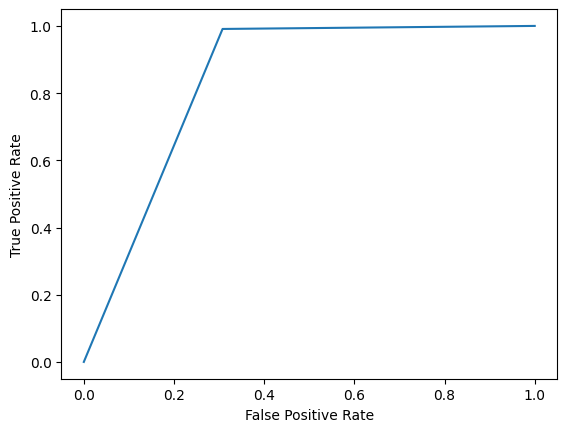

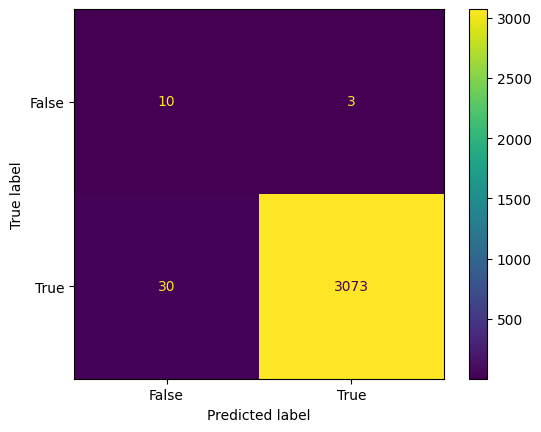

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.989089
Error Rate: 0.010911424903722766
Mean Recall: 0.8413198145715064
Balanced Accuracy Score: 0.8413198145715064
Precision: 0.6147346316342092
F-Score: 0.6703261140154344
3116 3116
Selectivity: 0.6923076923076923
G_mean: 0.7631855471107503


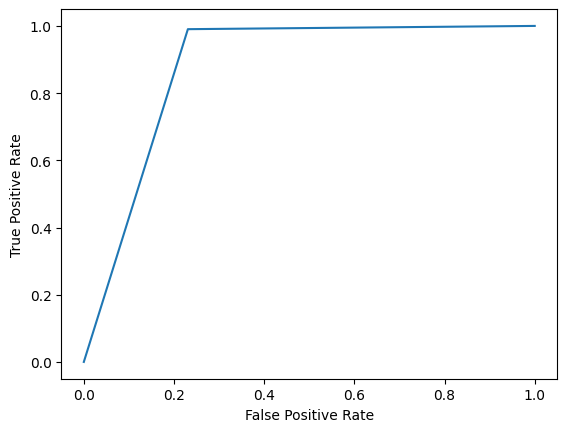

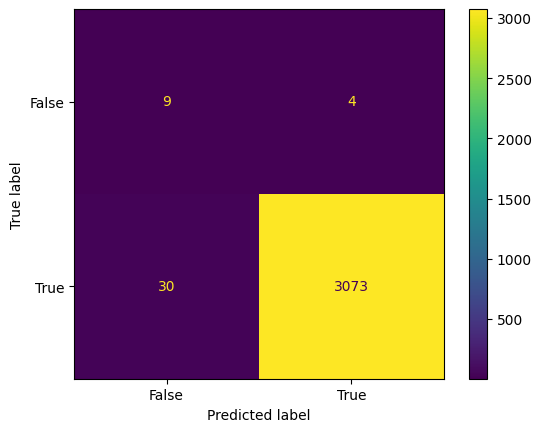

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.988447
Error Rate: 0.011553273427471145
Mean Recall: 0.879297949874811
Balanced Accuracy Score: 0.879297949874811
Precision: 0.6157909474114379
F-Score: 0.6756569207994079
3116 3116
Selectivity: 0.7692307692307693
G_mean: 0.822425095899462


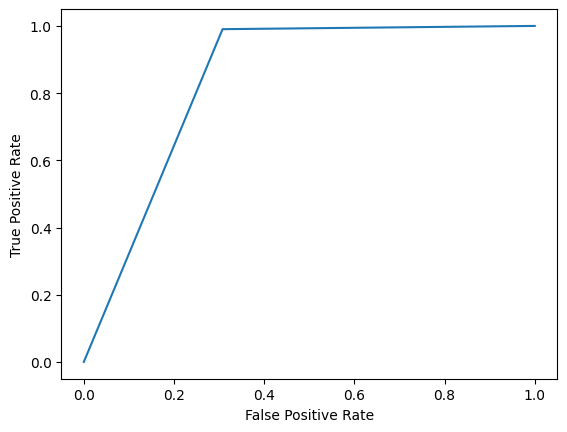

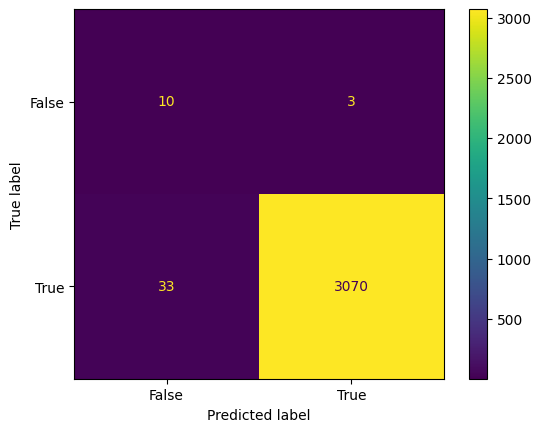

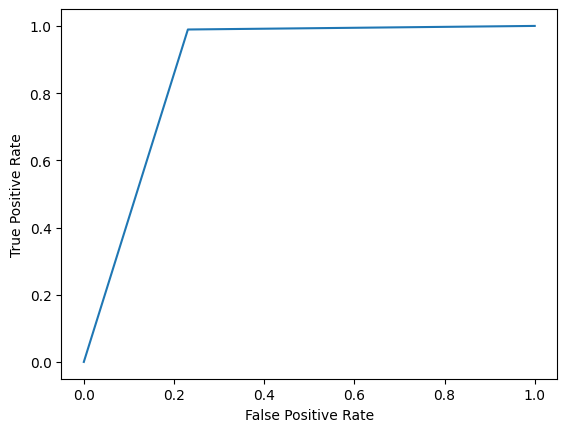

In [53]:
sm_list = []
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.991977
Error Rate: 0.008023106546854897
Mean Recall: 0.7661692158952874
Balanced Accuracy Score: 0.7661692158952874
Precision: 0.6336445108289769
F-Score: 0.6774687716073151
3116 3116
Selectivity: 0.5384615384615384
G_mean: 0.6423026192635735


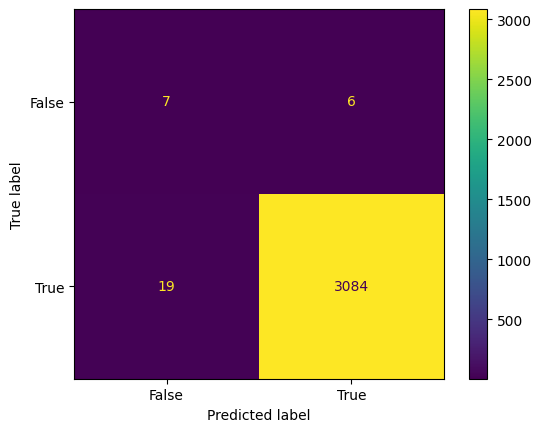

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.992298
Error Rate: 0.007702182284980763
Mean Recall: 0.8046307543568259
Balanced Accuracy Score: 0.8046307543568259
Precision: 0.6473388247425153
F-Score: 0.6980620155038759
3116 3116
Selectivity: 0.6153846153846154
G_mean: 0.7036742053653156


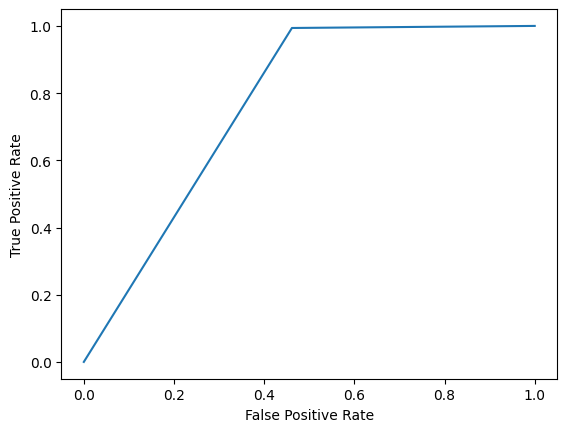

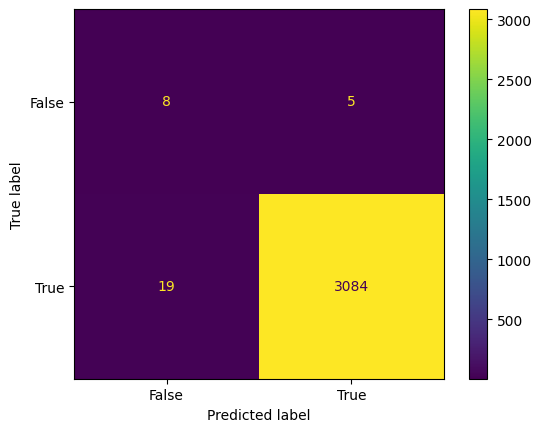

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.992298
Error Rate: 0.007702182284980763
Mean Recall: 0.8046307543568259
Balanced Accuracy Score: 0.8046307543568259
Precision: 0.6473388247425153
F-Score: 0.6980620155038759
3116 3116
Selectivity: 0.6153846153846154
G_mean: 0.7036742053653156


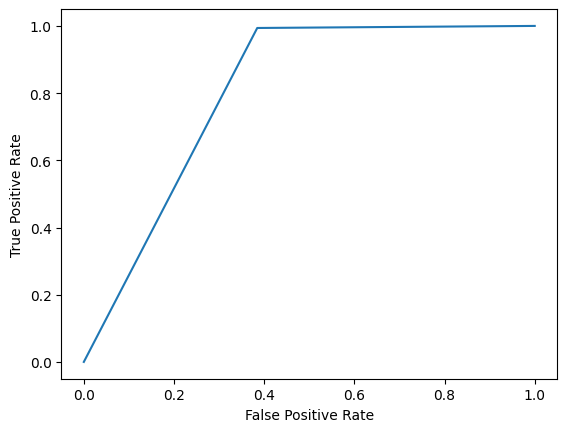

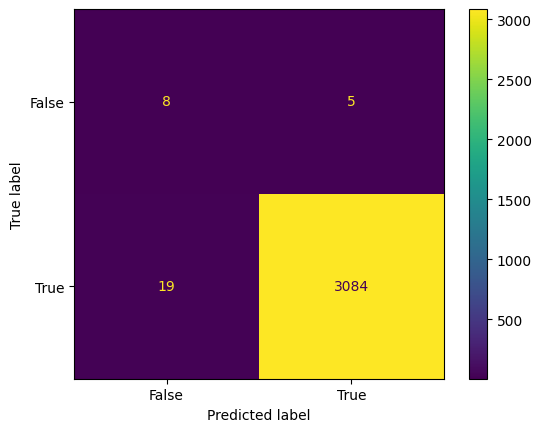

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.993261
Error Rate: 0.00673940949935814
Mean Recall: 0.7668137534395993
Balanced Accuracy Score: 0.7668137534395993
Precision: 0.6581212904742316
F-Score: 0.6983056317573019
3116 3116
Selectivity: 0.5384615384615384
G_mean: 0.6425727300396069


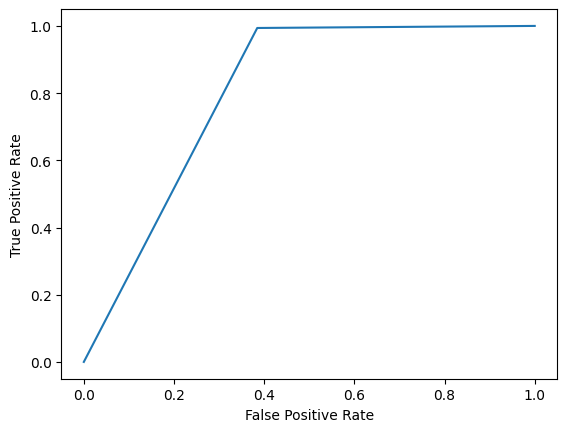

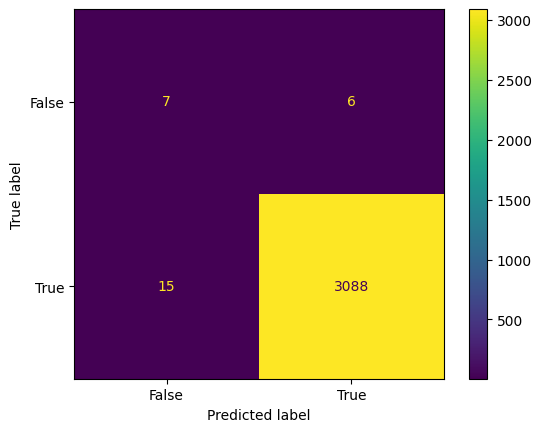

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.994544
Error Rate: 0.005455712451861383
Mean Recall: 0.7674582909839114
Balanced Accuracy Score: 0.7674582909839114
Precision: 0.6934760777562585
F-Score: 0.7244357049591377
3116 3116
Selectivity: 0.5384615384615384
G_mean: 0.6428427273200342


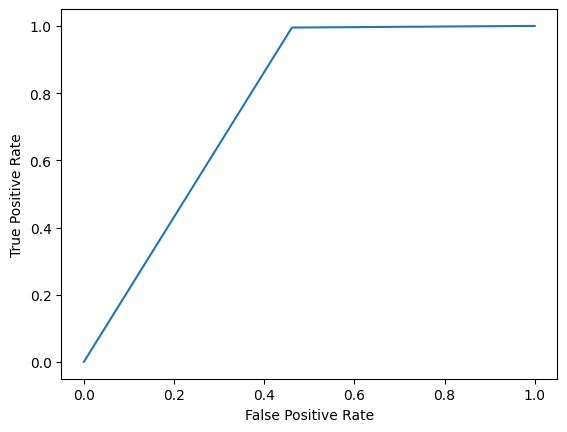

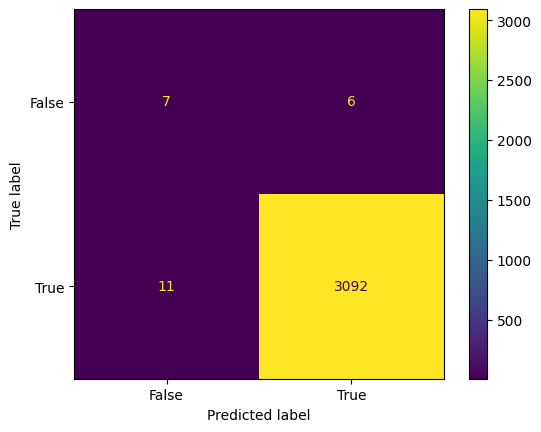

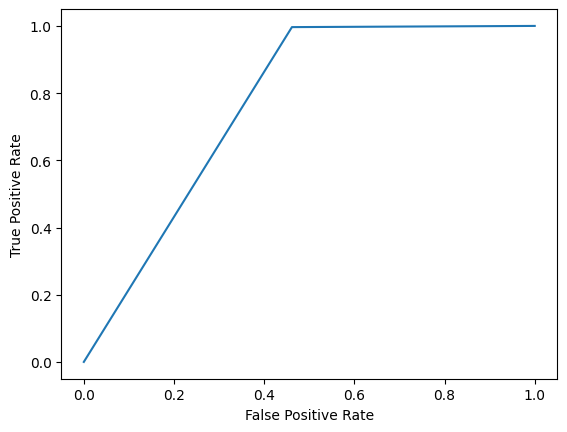

In [54]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))

for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)